In [90]:
import numpy as np
import numba as nb
import math as ma
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Definition of prior distributions and independent priors

In [105]:
class prior_model:
    def __init__(self, name, parm_name, a , b):
        self.name = name
        self.parm_name = parm_name
        self.a = a
        self.b = b
    
    def set_logp(self):
        a, b = self.a, self.b
        if self.name == "gamma":
            def logp(x):
                if x > 0:
                    return(( a - 1) * np.log(x) - b * x + a * np.log(b) - np.log(ma.gamma(a)))
                else:
                    return(-np.inf)
        elif self.name == "beta":
            def logp(x):
                if x>0:
                    return((a - 1)*np.log(x) + (b - 1)*np.log(1 - x) -  np.log(ma.gamma(a)) - np.log(ma.gamma(b)) + np.log(ma.gamma(a + b)))
                else:
                    return(-np.inf)
        elif self.name == "uniform":
            def logp(x):
                if x > a and x < b:
                    return(-np.log(b-a))
                else:
                    return(-np.inf)
        elif self.name == "normal":
            def logp(x):
                return(- np.log(2 * ma.pi) / 2 - (x-a)**2 / 2 / b**2 )
        self.logp = nb.jit(nopython = True)(logp)
    
    def sample(self, n):
        if self.name == "gamma":
            return(np.random.gamma(self.a, 1 / self.b, size = n))
        elif self.name == "beta":
            return(np.random.beta(self.a, self.b, size = n))
        elif self.name == "uniform":
            return(np.random.uniform(low = self.a, high = self.b, size = n))
        elif self.name == "normal":
            return(np.random.normal(self.a, self.b, size = n))

    

## Check of the log likelihood function 

In [183]:
λ1_prior, p_prior, γ_prior, μ_prior = prior_model("gamma", "λ1", 0.1, 0.1), prior_model("beta", "p", 0.5, 0.5) , prior_model("uniform", "γ", 0, 2), prior_model("normal", "μ", 0, 1) 
λ1_prior.set_logp(), p_prior.set_logp(), γ_prior.set_logp(), μ_prior.set_logp()
x = 0.1
print(λ1_prior.logp(0.1) - np.log(st.gamma.pdf(0.1 * λ1_prior.b, λ1_prior.a)*λ1_prior.b))
print(p_prior.logp(x) - np.log(st.beta.pdf(x, p_prior.a, p_prior.b)))
print(γ_prior.logp(x) - np.log(st.uniform.pdf(x) / (γ_prior.b - γ_prior.a)))
print(μ_prior.logp(x) - np.log(st.norm.pdf( (x - μ_prior.a ))  / μ_prior.b  ))

2.220446049250313e-16
1.6653345369377348e-16
0.0
0.0


## Check of the sampling function

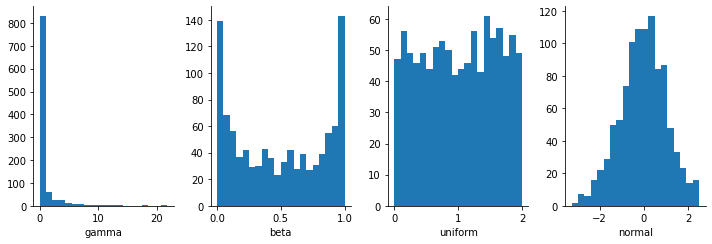

In [184]:
n, d = 1000, 4
λ1_sample, p_sample, γ_sample, μ_sample = λ1_prior.sample(n), p_prior.sample(n), γ_prior.sample(n), μ_prior.sample(n)
samples = [λ1_sample, p_sample, γ_sample, μ_sample ]
fig, axs = plt.subplots(1, d, figsize=(10, 3.5))
x_labs = [λ1_prior.name, p_prior.name, γ_prior.name, μ_prior.name]
for k in range(d):
    axs[k].hist(samples[k],bins=20)
    axs[k].set_xlabel(x_labs[k])
sns.despine()
fig.tight_layout()

In [149]:
class independent_priors:
    def __init__(self, priors):
        self.priors = priors
        self.parm_names = [prior.parm_name for prior in priors]
        self.d = len(priors)
    
    def sample(self,n):
        particle_cloud = pd.DataFrame(
            np.array([prior.sample(n) for prior in self.priors]).T)
        particle_cloud.columns = self.parm_names
        return(particle_cloud)
    
    def set_logp(self):
        [prior.set_logp() for prior in self.priors]
        def logp(parms):
            d = len(parms)
            return(np.sum([self.priors[k].logp(parms[k]) for k in range(d)]))
        self.logp = logp

In [146]:
prior_dist = independent_priors([λ1_prior, p_prior, γ_prior, μ_prior])
prior_dist.set_logp()
particle_cloud = prior_dist.sample(10)
np.array([prior_dist.logp(particle) for particle in particle_cloud.values])
    

array([-4.85354544,  3.7259834 , -3.4390096 ,  0.94467033,  4.80831993,
       -0.26984526, -3.94311431,  1.20798716, 21.47513131, 11.78252556])

In [156]:
def logp_gamma_beta_prior(a, b):
    def logp_prior(parms):
        gammas, beta, a_gammas, a_beta, b_gammas, b_beta = parms[:len(parms)-1], parms[-1], a[:len(parms)-1], a[-1], b[:len(parms)-1], b[-1]
        if np.all(parms)>0 and beta < 1:
            l_gamma =  np.sum((a_gammas - 1) * np.log(gammas)) - np.sum(gammas * b_gammas) + np.sum(a_gammas * np.log(b_gammas)) - np.sum(np.log(np.array([ma.gamma( a_scalar ) for a_scalar in a_gammas])))
            l_beta = (a_beta - 1)*np.log(beta) + (b_beta - 1)*np.log(1 - beta) -  np.log(ma.gamma(a_beta)) - np.log(ma.gamma(b_beta)) + np.log(ma.gamma(a_beta + b_beta))

            return(l_gamma + l_beta)
        else:
            return(-np.inf)
    return nb.jit(nopython=True)(logp_prior)

In [177]:
λ1_prior, λ2_prior, γ_prior, p_prior = prior_model("gamma", "λ1", 0.1, 0.1), prior_model("gamma", "λ2", 0.1, 0.1), prior_model("gamma", "γ", 0.1, 0.1), prior_model("beta", "p", 2, 2)
prior_dist = independent_priors([λ1_prior, λ2_prior, γ_prior, p_prior])
particle_cloud = prior_dist.sample(10)
prior_dist.set_logp()
print(particle_cloud)
a, b = np.append(0.1*np.ones(prior_dist.d-1), 2), np.append(0.1*np.ones(prior_dist.d-1), 2.0)
log_prob_prior = logp_gamma_beta_prior(a, b) 

             λ1            λ2             γ         p
0  1.328366e-03  6.211661e-03  1.329314e-05  0.678007
1  3.364872e-02  4.254594e-04  4.981219e-06  0.492331
2  1.216055e-01  5.940712e+00  9.414056e-01  0.261861
3  6.724061e-03  5.433501e+00  2.886426e+00  0.413092
4  1.611339e-01  1.284240e-06  4.824091e-07  0.884067
5  4.493754e-05  4.100576e-13  2.762029e-02  0.535482
6  3.462108e-01  1.159455e-04  1.748957e-05  0.492377
7  4.606624e-04  4.393322e-09  2.275094e-04  0.361433
8  1.458756e-02  2.213882e-01  3.636467e+01  0.500162
9  2.796868e-14  1.808160e-21  4.010450e-14  0.478792


In [178]:
np.array([log_prob_prior(particle) for particle in particle_cloud.values]) - np.array([prior_dist.logp(particle) for particle in particle_cloud.values])

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.88178420e-16,
        0.00000000e+00,  1.06581410e-14,  0.00000000e+00,  0.00000000e+00,
       -3.55271368e-15,  0.00000000e+00])

In [179]:
%time np.array([log_prob_prior(particle) for particle in particle_cloud.values])
%time np.array([prior_dist.logp(particle) for particle in particle_cloud.values])

Wall time: 0 ns
Wall time: 0 ns


array([13.46032365, 13.98046976, -7.65411843, -5.8822772 , 18.99056631,
       30.85846512, 11.89098792, 24.65947959, -8.77586984, 91.79001189])